<a href="https://colab.research.google.com/github/YogithL/Data-Science/blob/main/Unit_6_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# **Forecasting Nvidia Stock Returns through Autoregression**


Price forecasting is a complex process that has many approaches; in this project, I'm exploring one route: autoregression. This method relies on identifying and leveraging the temporal dependencies---if any---within Nvidia's closing prices. Essentially, the program takes historical points, assigns them weights, and extrapolates these patterns to predict a price.

**NVDA is a leading computer chip manufacturer that has surged in popularity because of rapid development in AI.*

## **The Data**


The data below was extracted from Yahoo Finance and contains the closing prices of NVDA from June 11th, 2024; this was right after their stock split.

In [2]:
nvda= pd.read_csv('https://raw.githubusercontent.com/YogithL/Data-Science/refs/heads/main/NVDA%20Stock%20Data%20-%20Sheet1%20(1).csv')
nvda = nvda[::-1] #Reverses the order so the latest stock price is at the end
nvda

,Date,Open,High,Low,Close,Adj Close
154,6/11/2024,121.77,122.87,118.74,120.91,120.89
153,6/12/2024,123.06,126.88,122.57,125.20,125.18
152,6/13/2024,129.39,129.80,127.16,129.61,129.59
151,6/14/2024,129.96,132.84,128.32,131.88,131.86
150,6/17/2024,132.99,133.73,129.58,130.98,130.96
...,...,...,...,...,...,...
4,1/16/2025,138.64,138.75,133.49,133.57,133.57
3,1/17/2025,136.69,138.50,135.46,137.71,137.71
2,1/21/2025,139.16,141.83,137.09,140.83,140.83
1,1/22/2025,144.66,147.79,143.67,147.07,147.07


We could build the model using closing prices, but Conditional Autoregression requires stationary data with a constant variance and mean. Raw stock prices are too volatile, making it difficult for the model to detect patterns (Navani). Instead, using Log returns allows us to model day-to-day percent changes, reducing noise and improving the model's accuracy.

In [3]:
#Adding a new row in my data for log returns. Shifting by 1 moves all the values down by 1 so we can divide the current price by the previous one.
nvda['Log Returns']= np.log(nvda['Adj Close'] /nvda['Adj Close'].shift(1))

#Removing the NAN row
nvda.dropna(inplace=True)

nvda

,Date,Open,High,Low,Close,Adj Close,Log Returns
153,6/12/2024,123.06,126.88,122.57,125.20,125.18,0.034872
152,6/13/2024,129.39,129.80,127.16,129.61,129.59,0.034623
151,6/14/2024,129.96,132.84,128.32,131.88,131.86,0.017365
150,6/17/2024,132.99,133.73,129.58,130.98,130.96,-0.006849
149,6/18/2024,131.14,136.33,130.69,135.58,135.56,0.034522
...,...,...,...,...,...,...,...
4,1/16/2025,138.64,138.75,133.49,133.57,133.57,-0.019792
3,1/17/2025,136.69,138.50,135.46,137.71,137.71,0.030524
2,1/21/2025,139.16,141.83,137.09,140.83,140.83,0.022403
1,1/22/2025,144.66,147.79,143.67,147.07,147.07,0.043355


***

## **Visualizations**

Now that we have our data prepped, let's graph it.

Text(0, 0.5, 'Log Returns (%)')

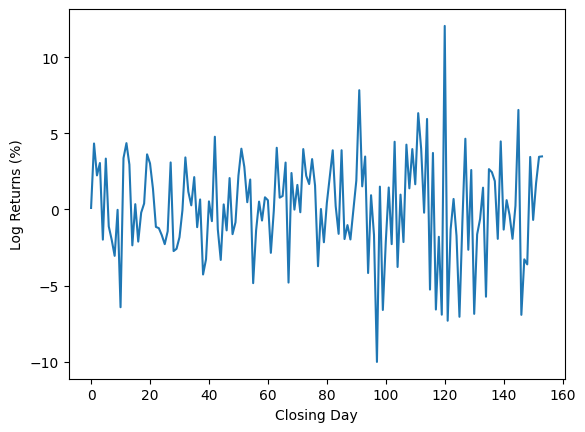

In [4]:
#A graph of the log returns for each of the 154 days
plt.plot(nvda['Log Returns']*100)

plt.xlabel("Closing Day")
plt.ylabel("Log Returns (%)")

Aside from the few high-magnitude spikes, the data appears to follow a discernable pattern, good news for our model.

<Axes: xlabel='Log Returns', ylabel='Density'>

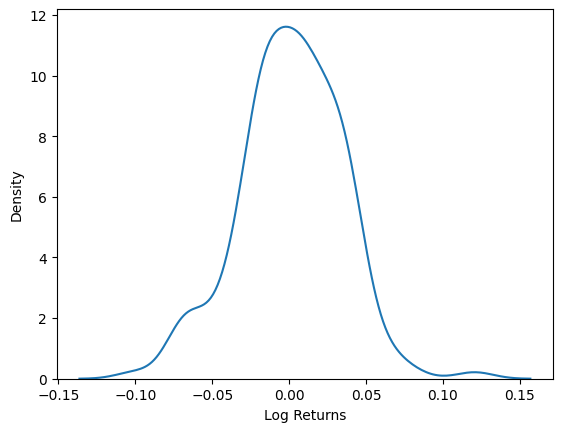

In [5]:
#Kdeplot and Rugplot so I can get a quick summary of the shape and frequency
sns.kdeplot(data=nvda, x="Log Returns")

The graph appears surprisingly normal, but since I'm using autocorrelation, I'll stick to the likelihood PyMC already has.

***

## **Preparation for our Model: Finding the Priors/Parameters**


PyMC's Conditional Autoregression likelihood (CAR) requires 4 parameters:

1. **mu** (mean)
2. **W** (weighted temporal matrix)
3. **alpha** (autoregression parameter)
4. **tau** (positive precision variable)

From PyMC's guide on using the likelihood, three parameters were already preset: $μ$ = 0, $\alpha$ ~ Normal, and $\tau$ ~ Gamma. After reviewing other sources, I noticed they used similar priors, so I followed the same approach. The gamma distribution, along  with the normal distribution, is highly flexible so the priors should be weak. However, I had to construct my own weighted matrix since it varies heavily on the nature of the data.

**I learned that setting the mean to 0 ensures that predictions are driven by the weighted influence of neighbors rather than introducing unnecessary bias.*

## **Creating the Temporal Weight Matrix**


To make a matrix, 3 conditions have to be followed:
1. Square (n x n)
2. Symmetric across the diagonal
3. No self loops (diagonal full of zeros)

Below is a valid example.

In [6]:
n= 3
example_matrix= np.zeros((n,n)) #making matrix full of zeros
for i in range(n-1): #filling the matrix with 1s so each day is influenced by its immediate past and present
  example_matrix[i+1, i]=1
  example_matrix[i, i+1]=1

example_matrix


array([[0., 1., 0.],
       [1., 0., 1.],
       [0., 1., 0.]])

To interpret this matrix, each row represents a time point (a closing day), and each column indicates the magnitude of influence from its associated time point. The matrix structure above could be understood as follows:
1. The 1st closing day was influenced by the price of the 2nd closing day
2. The 2nd closing day was influenced by the 1st price of the 3rd closing day
3. The 3rd closing day was influenced by the price of the 2nd closing day

This created a major issue: the second requirement (symmetry) meant the model would use future prices to influence predictions of present ones---something impossible in real life forecasting. As a result, the model isn't practical for true price prediction. However, since we're working with historical data, we can still build and analyze one.

I explored ways to work around this, but PyMC's CAR model is fundamentally designed for spatial, non temporal dependencies, making it less suited for time series.  

Regardless, I continued to test whether a workable model could be built. Below is the expanded version of the weight matrix from the earlier example, where n represents the total number of closing price data points available.

In [7]:
n=nvda.shape[0]
past_AR1_matrix= np.zeros((n,n))
for i in range(n-1):
  past_AR1_matrix[i+1, i]=1
  past_AR1_matrix[i, i+1]=1

past_AR1_matrix


array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.]])

## **Attempt 1: Creating the Model**


Now that we have the neccessary parameters, we can run our basic model. My hopes aren't high, so I'll be surprised if it actually runs smoothly.

In [8]:
with pm.Model(coords={"area_idx": np.arange(n)}) as past_AR1_model:
  tau= pm.Gamma("tau", alpha=1, beta=1)
  alpha= pm.Normal("alpha", mu=0, sigma=1)

  y= pm.CAR(
      "y", mu=np.zeros(n), W=past_AR1_matrix, alpha= alpha, tau=tau, dims="area_idx", observed= nvda['Log Returns'])

  data_1= pm.sample(target_accept = 0.95, return_inferencedata=True)

Output()

Output()

The first time around, I encountered over 100 divergences, but that was because I forgot to include the observed data in the model. Now that it's fixed, its time to see the posterior predictive distribution.

Output()

<Axes: xlabel='y'>

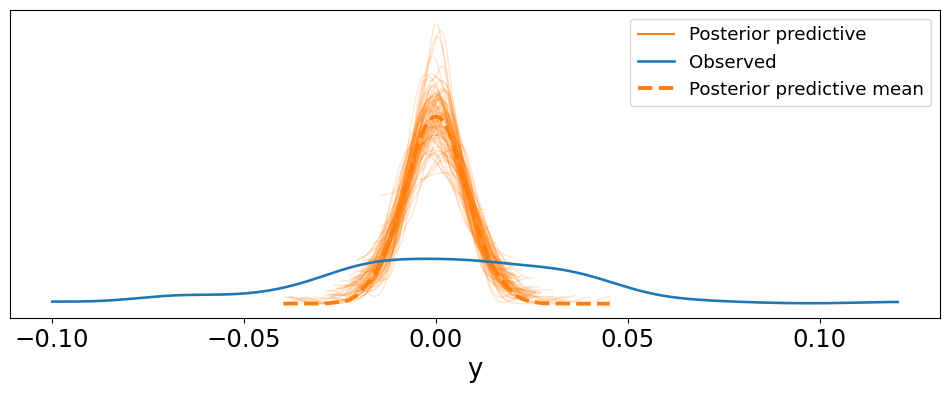

In [9]:
  pm.sample_posterior_predictive(data_1, model=past_AR1_model, extend_inferencedata=True)

  az.plot_ppc(data_1, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]) #alpha = .1 makes Posterior Predictive traces less opaque

The posterior predictive distribution turned out pretty horrible, but at least it follows the generic parabolic shape.

I think the primary issue for the model's performance is its AR(1) model order. Since the model is only influenced by prices 1 day in the past/future, it struggles to capture any meaningful trends. For my next attempt, I'll try to expand the model to account for influences across the entire of the 154-day range.


## **Attempt 2: Fixing the Model**


The new matrix below uses a double for-loop to fill all elements except the diagonals with 1s. In hindsight, I could've created a matrix of 1s and zeroed out the diagonal...

In [10]:
past_AR2_matrix= np.zeros((n,n)) #Making a matrix full of zeros

for i in range(n): #Loop over each row
  for j in range(1, n): #Loop over each column for n columns
    if i-j>=0: #Ensure we don't negative indices
      past_AR2_matrix[i, i-j]=1 #Past values predict current ones
      past_AR2_matrix[i-j, i]=1 #Same as above, flipped for symmetry
past_AR2_matrix

array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [11]:
with pm.Model(coords={"area_idx": np.arange(n)}) as past_AR2_model:
  tau= pm.Gamma("tau", alpha=1, beta=1)
  alpha= pm.Normal("alpha", mu=0, sigma=1)

  y= pm.CAR(
      "y", mu=np.zeros(n), W=past_AR2_matrix, alpha= alpha, tau=tau, dims="area_idx", observed= nvda['Log Returns'])

  data_2= pm.sample(target_accept = 0.95, return_inferencedata=True)

Output()

Output()

ERROR:pymc.stats.convergence:There were 676 divergences after tuning. Increase `target_accept` or reparameterize.


This new model resulted in 500+ divergences, and I realized I made a major mistake. First off, I incorrectly assumed that the current value was influenced by every price before and after it, which is already problematic. On top of that, I treated all those influences equally; so, regardless of whether the closing price was 100 days ago or just 2 days ago, both had the same magnitude of effect. In my next model, I'll try to implement a decaying influence structure and reduce the AR(n) structure  to something more manageable.

I was going to run a posterior predictive distribution for this failed model, but it looks like it'll take too long.

In [12]:
  #If anyone wants to run it

  #pm.sample_posterior_predictive(data_2, model=past_AR2_model, extend_inferencedata=True)

  #az.plot_ppc(data_2, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]) #alpha = .1 makes Posterior Predictive traces less opaque

## **Attempt 3: Fixing the Model Again**


This time, I've decided to apply a decaying influence to closing prices and limit the model to an AR(5)---reflecting the number of days in a trading week. In this new setup, the only influences on a stock's price come from closing values 5 days before and after, with greater weight given to more immediate days. This should help the model better capture the realistic, short-term dependencies in stock prices.

In [13]:
decay_factor=.2
decay_limit= 5

past_AR3_matrix= np.zeros((n,n)) #Making a matrix full of zeros

for i in range(n): #Loop over each row
  for j in range(1, decay_limit +1):  #Loop over 5 columns
    if i-j>=0: #Ensure we don't negative indices
      past_AR3_matrix[i, i-j]=decay_factor**j #Similar to earlier matrix; this time decaying rate depends on j
      past_AR3_matrix[i-j, i]=decay_factor**j #Same idea of symmetry

np.fill_diagonal(past_AR3_matrix, 0) #Ensuring diagonals are filled with zeros (no self-influence)
past_AR3_matrix

array([[0.  , 0.2 , 0.04, ..., 0.  , 0.  , 0.  ],
       [0.2 , 0.  , 0.2 , ..., 0.  , 0.  , 0.  ],
       [0.04, 0.2 , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , ..., 0.  , 0.2 , 0.04],
       [0.  , 0.  , 0.  , ..., 0.2 , 0.  , 0.2 ],
       [0.  , 0.  , 0.  , ..., 0.04, 0.2 , 0.  ]])

In [14]:
with pm.Model(coords={"area_idx": np.arange(n)}) as past_AR3_model:
  tau= pm.Gamma("tau", alpha=1, beta=1)
  alpha= pm.Normal("alpha", mu=0, sigma=1)

  y= pm.CAR(
      "y", mu=np.zeros(n), W=past_AR3_matrix, alpha= alpha, tau=tau, dims="area_idx", observed= nvda['Log Returns'])

  data_3= pm.sample(target_accept = 0.95, return_inferencedata=True)

Output()

Output()

Output()

<Axes: xlabel='y'>

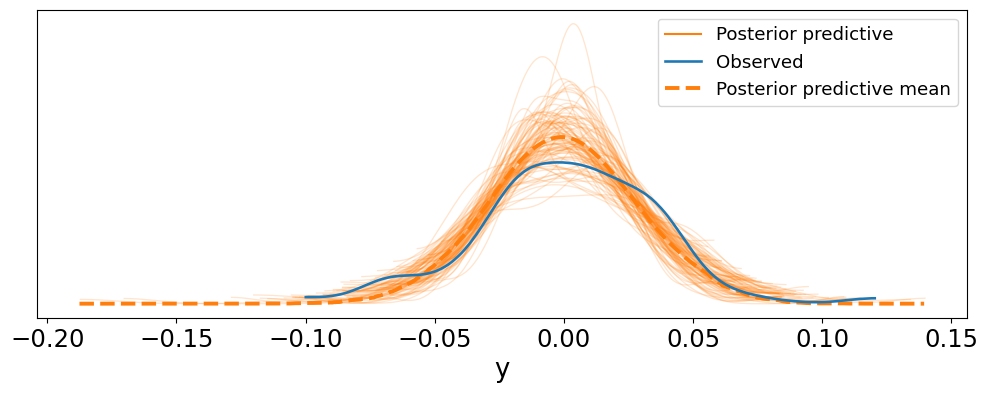

In [15]:
  pm.sample_posterior_predictive(data_3, model=past_AR3_model, extend_inferencedata=True)

  az.plot_ppc(data_3, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"]) #alpha = .1 makes Posterior Predictive traces less opaque

The posterior looks a lot better this time! I did tweak the decay rate, so the curve above isn't from my first attempt. Below, I'm creating an array to visualize our model's predictions for the days we inputted.

In [16]:
#Function from Unit 2 that we used to make predictions
pm.sample_posterior_predictive(data_3, model=past_AR3_model, extend_inferencedata=True)

#Stacking the two MCMC chains together
stacked_nvda = az.extract(data_3, group="posterior_predictive")

#Array of predicted log returns
stacked_nvda.sel(sample=0).sel(draw=0).y.to_series().values

#Creating new array of size n+1 to store actual prices, not log returns
prices_nvda= np.zeros(n+1)

#Storing the first price (that's why the size is n+1)
prices_nvda[0]= 120.89

#Iterating through the Log Returns and back into prices
for i in range(1, n+1):
    #instead of getting the entire array of log returns, we get each one indivually
    log_returns=stacked_nvda.sel(sample=0).sel(draw=0).y[i-1]

    #Formula for Log Return -> Price
    prices_nvda[i]= prices_nvda[i-1]*np.exp(log_returns)

prices_nvda

Output()

array([120.89      , 125.61424616, 122.07734752, 128.2012915 ,
       126.37727381, 130.88523671, 128.9832081 , 128.3606857 ,
       125.5687763 , 122.72847043, 129.19387317, 128.51997616,
       130.2566525 , 131.87234331, 132.01948313, 132.66143544,
       135.91571363, 130.51439367, 127.41754337, 130.64598574,
       124.08073349, 130.1239091 , 128.72238072, 134.65856417,
       130.11146201, 130.03026134, 132.78112293, 137.73150676,
       136.10936327, 141.62599669, 139.28174488, 143.47932316,
       144.87484276, 143.15454815, 145.96730094, 146.64555891,
       145.28640312, 145.44505798, 148.32676057, 154.97860564,
       151.19409715, 156.02715657, 154.48784811, 157.16717137,
       153.07451238, 151.777219  , 147.65437252, 140.52889105,
       148.97995001, 149.11364991, 143.6277097 , 147.02930511,
       147.57916313, 151.20332778, 149.00538542, 139.86308977,
       142.58629822, 141.70729652, 140.62720743, 147.02764841,
       148.36913028, 150.25322793, 154.38696817, 154.37

## **Final Thoughts**

Initially, the model followed a standard AR(1) structure, but after realizing it couldn't effectively capture trends, we transitioned to an AR(n) program. This brought its own challenges, including sensitivity to outdated prices and treating all closing prices with equal influence. Eventually, we shifted to an AR(5) structure where influence was decayed over time; this worked the best.

While the projections our model created weren't perfect---NVDA never dipped below $98 in our time frame---they could've been much worse. The model was fairly accurate at the start, began to underestimate later, and eventually began to overestimate.

One of the biggest flaws in the model was that we weren't able to create a weighted matrix that wasn't symmetrical; this made the model unrealistic. In the future, I'd like to find a better likelihood suited for temporal data and/or expirement with other forecasting methods beyond Autoregression.